In [52]:
# %pip install -r requirements.txt -q

In [1]:
import data
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm

from concurrent.futures import ThreadPoolExecutor
from data import *
from IPython.display import display
from itertools import product
from plotly.subplots import make_subplots


# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read & Process

## Read equities & cryptocurrencies data

In [2]:
print('*****Reading equity data*****')
df_equity = read_excel_sheets('data.xlsx')
display(df_equity.head())
list_equity = df_equity.Symbol.unique().tolist()

print('*****Reading cryptocurrency data*****')
df_crypto = read_excel_sheets('data_crypto.xlsx')
display(df_crypto.head())
list_crypto = df_crypto.Symbol.unique().tolist()

print('*****Concatenating both dfs*****')
df_full = pd.concat([df_equity, df_crypto])
display(df_full.sample(5))

print('*****Check for missing values*****\n', df_full.isna().sum())

*****Reading equity data*****
AAPL
MSFT
NVDA
AMZN
META
GOOGL
BRK.B
GOOG
AVGO
TSLA
SPY_ETF
DAXEX_ETF
CAC40_ETF
NKY225_ETF
DJIA_ETF
EQQQ_ETF
FTSE_ETF


,OpenTime,Open,High,Low,Close,Symbol
4371,2024-10-06 23:00:00,41070.0,41080.0,41000.0,41000.0,NKY225_ETF
4370,2024-10-06 23:05:00,41000.0,41060.0,40950.0,40980.0,NKY225_ETF
4369,2024-10-06 23:10:00,40960.0,40980.0,40930.0,40950.0,NKY225_ETF
4368,2024-10-06 23:15:00,40940.0,40990.0,40910.0,40930.0,NKY225_ETF
4367,2024-10-06 23:20:00,40940.0,40950.0,40890.0,40890.0,NKY225_ETF


*****Reading cryptocurrency data*****
Sheet1


,OpenTime,Open,High,Low,Close,Symbol
0,2024-10-04 16:00:00,0.35170,0.35220,0.35160,0.35210,ADAUSDT
1,2024-10-04 16:00:00,26.27000,26.32000,26.25000,26.32000,AVAXUSDT
2,2024-10-04 16:00:00,555.30000,556.40000,555.20000,556.30000,BNBUSDT
3,2024-10-04 16:00:00,62086.00000,62214.00000,62085.99000,62198.02000,BTCUSDT
4,2024-10-04 16:00:00,0.10924,0.10958,0.10923,0.10953,DOGEUSDT


*****Concatenating both dfs*****


,OpenTime,Open,High,Low,Close,Symbol
1521,2024-12-18 13:10:00,455.7500,455.7600,455.1000,455.2650,BRK.B
244516,2024-12-28 13:35:00,193.3600,193.8600,193.3400,193.8000,SOLUSDT
757,2025-01-03 14:20:00,452.1100,452.6850,451.9210,452.2909,BRK.B
105538,2024-11-10 07:25:00,0.9991,0.9992,0.9991,0.9992,USDCUSDT
267295,2025-01-05 11:25:00,3633.3000,3636.4200,3632.7700,3634.3500,ETHUSDT


*****Check for missing values*****
 OpenTime    0
Open        0
High        0
Low         0
Close       0
Symbol      0
dtype: int64


# Pair Trading Example

## Prepare the pair trading series

In [3]:
seriesX = 'NVDA'
seriesY = 'BNBUSDT'

price_pairs1 = process_pairs_series(seriesX, seriesY, dfX=df_equity, dfY=df_crypto)
display(price_pairs1.head())

seriesX = 'DJIA_ETF'
seriesY = 'AVAXUSDT'

price_pairs2 = process_pairs_series(seriesX, seriesY, dfX=df_equity, dfY=df_crypto)
display(price_pairs2.head())

,NVDA,BNBUSDT
OpenTime,,
2024-10-14 12:30:00,137.98,588.6
2024-10-14 12:35:00,138.04,588.7
2024-10-14 12:40:00,137.60,589.0
2024-10-14 12:45:00,138.10,588.1
2024-10-14 12:50:00,138.64,588.0


,DJIA_ETF,AVAXUSDT
OpenTime,,
2024-10-14 12:30:00,427.88,29.17
2024-10-14 12:35:00,427.66,29.17
2024-10-14 12:40:00,427.92,29.20
2024-10-14 12:45:00,428.53,29.15
2024-10-14 12:50:00,428.00,29.17


## Test for Augmented Dickey-Fuller (ADF), Cointegration & Correlation

In [4]:
priceX = price_pairs1.iloc[:, 0]
priceY = price_pairs1.iloc[:, 1]

coint_stat, p_value, crit_values = coint(priceX, priceY)

# Print the results
print('Cointegration Test Results:')
print(f'Test Statistic: {coint_stat:.4f}')
print(f'P-Value: {p_value:.4f}')
print(f'Critical Values (1%, 5%, 10%): {crit_values}')

Cointegration Test Results:
Test Statistic: -3.0071
P-Value: 0.1085
Critical Values (1%, 5%, 10%): [-3.89887649 -3.33748874 -3.04539304]


Pair: NVDA & BNBUSDT
Correlation: -0.129

Spread ADF Statistic: -1.6212
p-value: 0.472 (Spread is non-stationary)

Cointegration Test Statistic: -3.0071
p-value: 0.109 (Both series are not cointegrated)


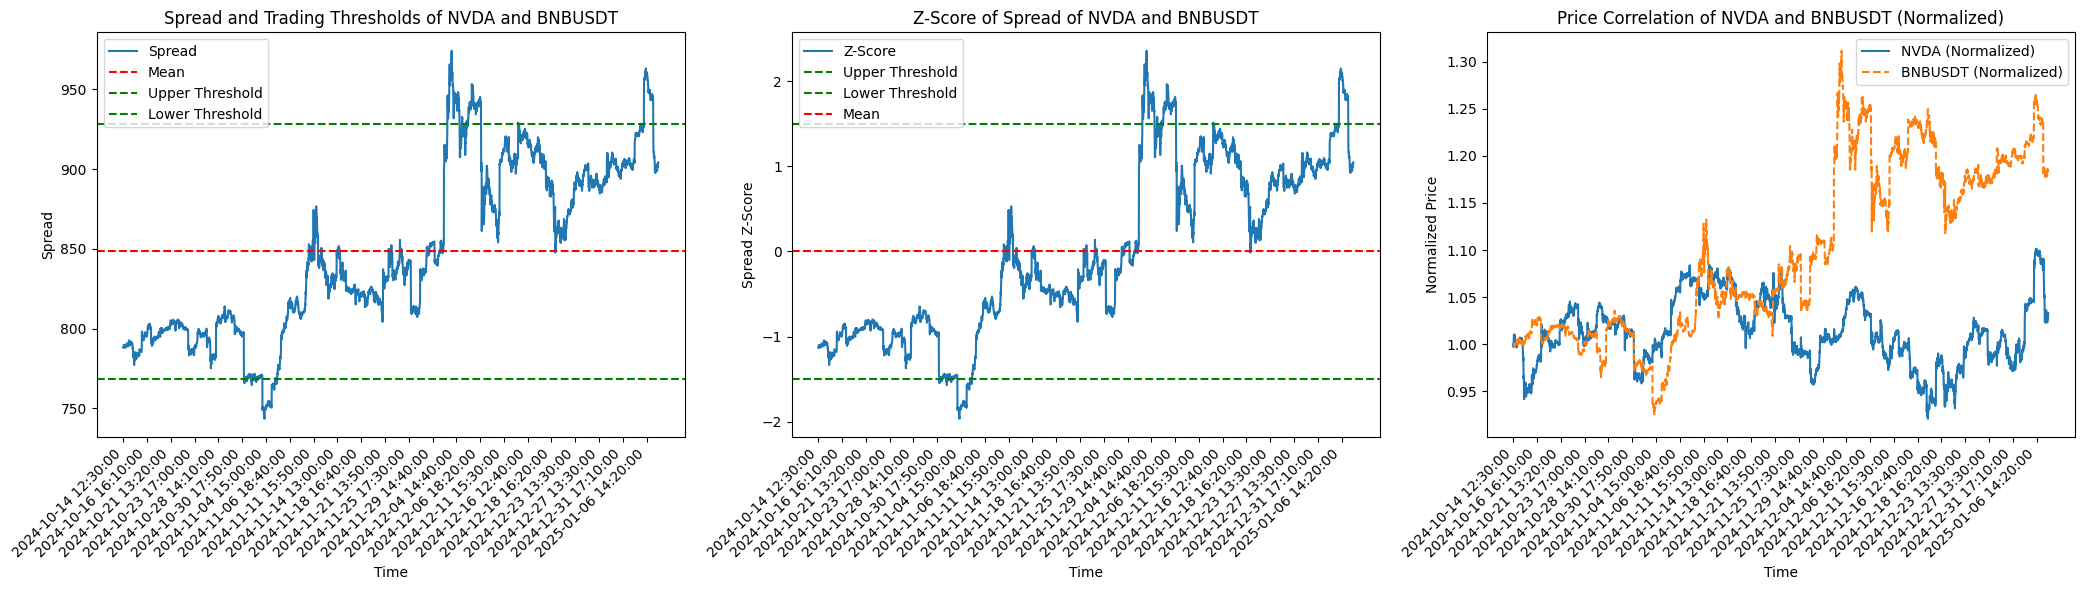

In [11]:
spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs1, print_stats=True, plotting=True, std=1.5)

Pair: NVDA & BNBUSDT
Correlation: -0.129

Spread ADF Statistic: -1.6212
p-value: 0.472 (Spread is non-stationary)

Cointegration Test Statistic: -3.0071
p-value: 0.109 (Both series are not cointegrated)


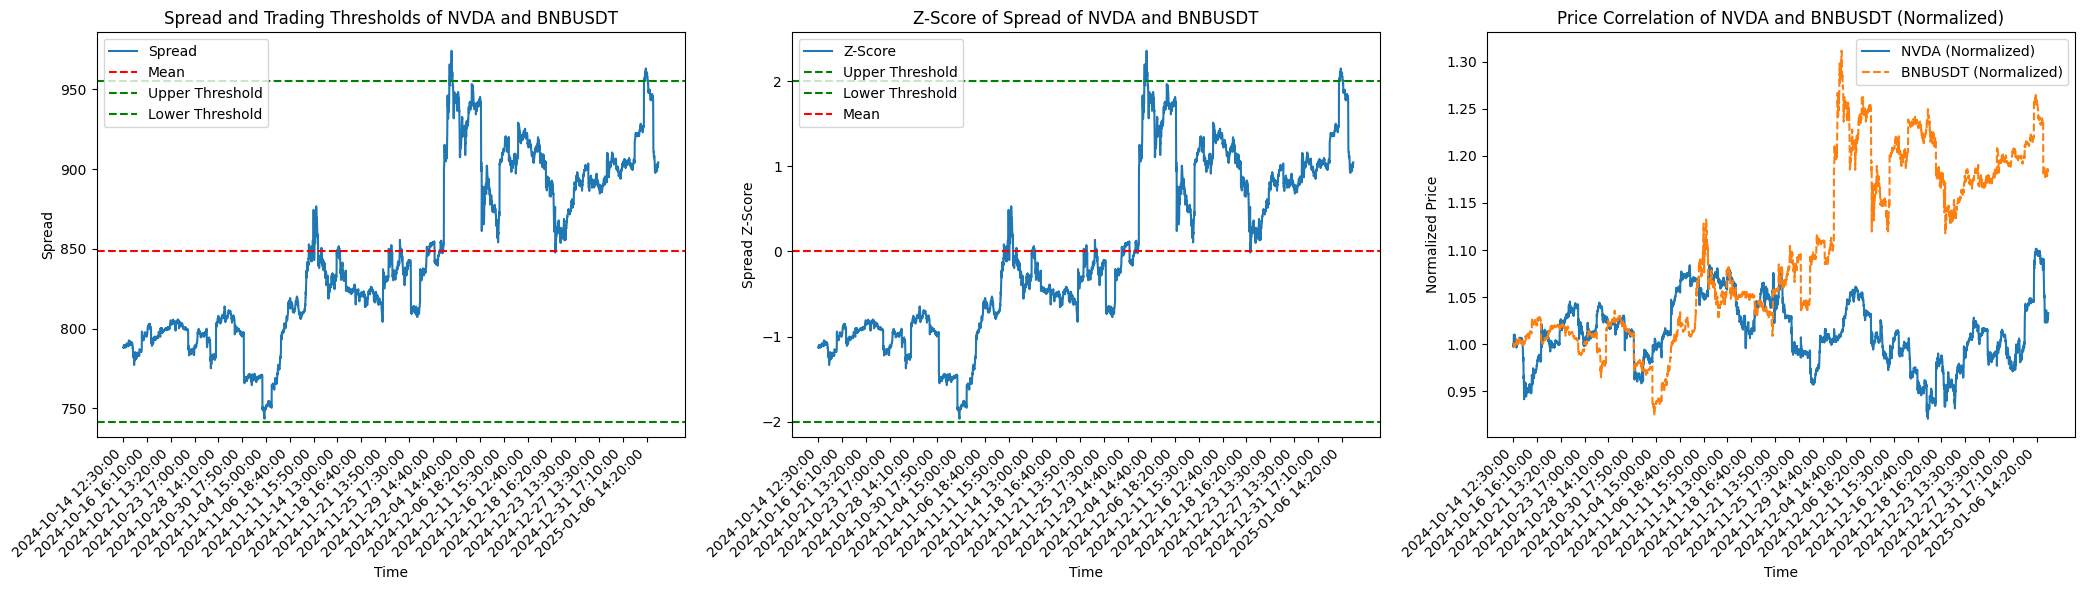

In [12]:
spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs1, print_stats=True, plotting=True, std=2)

Pair: DJIA_ETF & AVAXUSDT
Correlation: 0.712

Spread ADF Statistic: -1.8792
p-value: 0.342 (Spread is non-stationary)

Cointegration Test Statistic: -2.1254
p-value: 0.463 (Both series are not cointegrated)


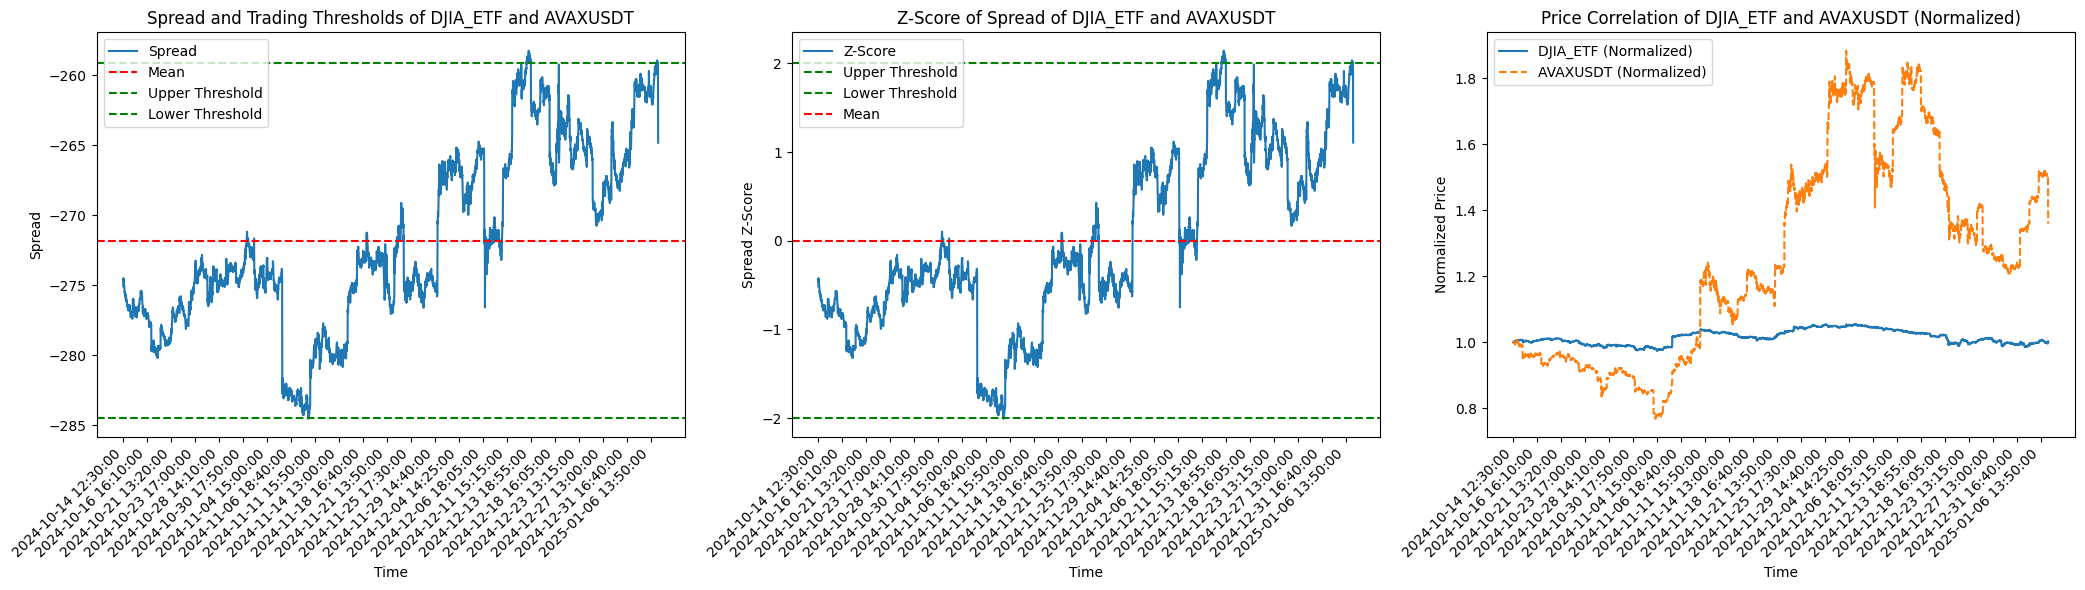

In [13]:
spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs2, print_stats=True, plotting=True, std=2)

In [14]:
spread, correlation, adf_result, coint_result

(OpenTime
 2024-10-14 12:30:00   -274.629973
 2024-10-14 12:35:00   -274.473770
 2024-10-14 12:40:00   -274.628373
 2024-10-14 12:45:00   -275.111480
 2024-10-14 12:50:00   -274.715174
                           ...    
 2025-01-06 18:45:00   -259.019753
 2025-01-06 18:50:00   -259.229857
 2025-01-06 18:55:00   -259.627463
 2025-01-07 12:30:00   -264.680583
 2025-01-07 12:35:00   -264.799386
 Length: 4464, dtype: float64,
 np.float64(0.7120375971895431),
 (np.float64(-1.879213492563332),
  np.float64(0.34190202707532863),
  11,
  4452,
  {'1%': np.float64(-3.4318196932722165),
   '5%': np.float64(-2.8621894279095677),
   '10%': np.float64(-2.567115694284003)},
  np.float64(4104.803525883391)),
 (np.float64(-2.1254081470585597),
  np.float64(0.46309476303747826),
  array([-3.89889562, -3.3374994 , -3.04540044])))

In [15]:
equity_pairs = [pair for pair in product(list_equity, list_equity)]
eq_cr_pairs = [pair for pair in product(list_equity, list_crypto)]
crypto_pairs = [pair for pair in product(list_crypto, list_crypto)]

all_pairs = equity_pairs + eq_cr_pairs + crypto_pairs
all_pairs[:5]

[('NKY225_ETF', 'NKY225_ETF'),
 ('NKY225_ETF', 'AAPL'),
 ('NKY225_ETF', 'AMZN'),
 ('NKY225_ETF', 'AVGO'),
 ('NKY225_ETF', 'BRK.B')]

In [11]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_single_pair(pair):
    ticker1, ticker2 = pair
    if ticker1 == ticker2:
        return None
        
    # Prepare for pair prices
    price_pairs = process_pairs_series(ticker1, ticker2, df=df_full)
    if price_pairs.empty:
        print(f'Pair {ticker1} and {ticker2} has no common trading hours.')
        return None
    else:
        spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs, print_stats=False, plotting=False)
        
        # Unpack adf result
        adf_stat, adf_pv, _, num_observations, *_ = adf_result
        # Check for Spread stationarity
        spread_stationary = adf_pv <= 0.05
        # Unpack cointegration result
        coint_stat, coint_pv, crit_values = coint_result
        # Check for Series cointegration
        series_coint = coint_pv <= 0.05
        
        return {
            'seriesX': ticker1,
            'seriesY': ticker2,
            'correlation': correlation,
            'spread_adf_stat': adf_stat,
            'spread_adf_pValue': adf_pv,
            'spread_stationary': spread_stationary,
            'series_coint_stat': coint_stat,
            'series_coint_pValue': coint_pv,
            'series_cointegrated': series_coint
        }

list_results = []

with ThreadPoolExecutor(max_workers=2) as executor:
    # Submit all pairs for processing
    future_to_pair = {executor.submit(process_single_pair, pair): pair for pair in all_pairs}
    
    # Collect results as they complete
    for future in as_completed(future_to_pair):
        result = future.result()
        if result is not None:
            list_results.append(result)

print(f'Number of potential trading pairs: {len(list_results)}')

Pair NKY225_ETF and AMZN has no common trading hours.
Pair NKY225_ETF and AAPL has no common trading hours.
Pair NKY225_ETF and BRK.B has no common trading hours.
Pair NKY225_ETF and AVGO has no common trading hours.
Pair NKY225_ETF and DJIA_ETF has no common trading hours.
Pair NKY225_ETF and GOOG has no common trading hours.
Pair NKY225_ETF and GOOGL has no common trading hours.
Pair NKY225_ETF and META has no common trading hours.
Pair NKY225_ETF and MSFT has no common trading hours.
Pair NKY225_ETF and NVDA has no common trading hours.
Pair NKY225_ETF and SPY_ETF has no common trading hours.
Pair NKY225_ETF and TSLA has no common trading hours.
Pair NKY225_ETF and DAXEX_ETF has no common trading hours.
Pair NKY225_ETF and CAC40_ETF has no common trading hours.
Pair NKY225_ETF and EQQQ_ETF has no common trading hours.
Pair AAPL and NKY225_ETF has no common trading hours.
Pair NKY225_ETF and FTSE_ETF has no common trading hours.
Pair AMZN and NKY225_ETF has no common trading hours.
P

In [12]:
df_results = pd.DataFrame(list_results)
display(df_results.sample(5))

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
144,NVDA,SPY_ETF,0.149389,-1.857226,0.352443,False,-2.797502,0.166481,False
405,FTSE_ETF,ETHUSDT,0.501239,-1.920413,0.322520,False,-1.864661,0.597816,False
152,SPY_ETF,AVGO,0.110179,-0.436513,0.903822,False,-2.051806,0.501566,False
81,GOOG,META,0.730512,-2.882662,0.047402,True,-2.279375,0.383888,False
52,BRK.B,MSFT,-0.011330,-2.187362,0.210864,False,-2.084526,0.484458,False


In [17]:
df_results.spread_stationary.value_counts(), df_results.series_cointegrated.value_counts()

(spread_stationary
 False    424
 True      76
 Name: count, dtype: int64,
 series_cointegrated
 False    471
 True      29
 Name: count, dtype: int64)

In [32]:
# df_results.to_csv('spread_analysis.csv', index=False)

## Visualizing Correlations

seriesX,AAPL,ADAUSDT,AMZN,AVAXUSDT,AVGO,BNBUSDT,BRK.B,BTCUSDT,CAC40_ETF,DAXEX_ETF,...,META,MSFT,NKY225_ETF,NVDA,SOLUSDT,SPY_ETF,TRXUSDT,TSLA,USDCUSDT,XRPUSDT
seriesX,,,,,,,,,,,,,,,,,,,,,
AAPL,1.00,0.40,0.91,0.43,0.86,0.61,-0.37,0.35,-0.63,0.92,...,0.91,0.89,0.94,-0.73,0.40,0.44,0.66,0.91,0.94,0.66
ADAUSDT,0.40,1.00,0.95,1.00,-0.21,0.97,0.78,1.00,-0.25,0.63,...,0.73,0.84,0.19,0.60,0.97,0.99,0.95,0.96,0.22,0.95
AMZN,0.91,0.95,1.00,0.95,0.77,0.99,-0.12,0.93,-0.60,0.90,...,0.92,0.91,0.45,-0.46,0.93,0.63,0.99,0.99,0.80,0.99
AVAXUSDT,0.43,1.00,0.95,1.00,-0.18,0.97,0.77,0.99,-0.29,0.65,...,0.74,0.85,0.20,0.60,0.97,0.99,0.96,0.97,0.38,0.96
AVGO,0.86,-0.21,0.77,-0.18,1.00,-0.05,-0.77,-0.28,-0.56,0.80,...,0.82,0.69,0.85,-0.85,-0.48,0.08,0.06,0.76,0.95,0.01
BNBUSDT,0.61,0.97,0.99,0.97,-0.05,1.00,0.66,0.95,-0.34,0.80,...,0.88,0.94,0.39,0.41,0.93,0.95,1.00,0.98,0.85,1.00
BRK.B,-0.37,0.78,-0.12,0.77,-0.77,0.66,1.00,0.82,0.23,-0.29,...,-0.30,-0.03,-0.43,0.80,0.96,0.59,0.61,-0.12,-0.99,0.62
BTCUSDT,0.35,1.00,0.93,0.99,-0.28,0.95,0.82,1.00,-0.22,0.58,...,0.68,0.79,0.13,0.65,0.98,0.99,0.93,0.96,-0.28,0.93
CAC40_ETF,-0.63,-0.25,-0.60,-0.29,-0.56,-0.34,0.23,-0.22,1.00,-0.52,...,-0.44,-0.45,-0.31,0.29,-0.37,-0.22,-0.41,-0.68,-0.44,-0.34


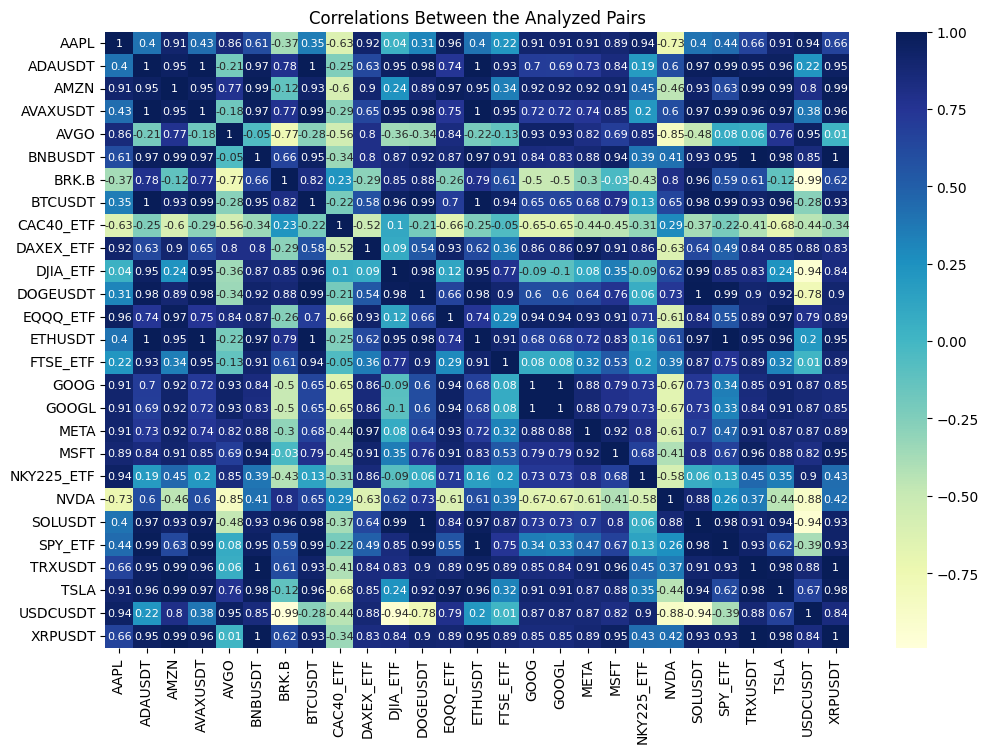

In [18]:
# Extract the pairwise correlations
df_temp = df_results[['seriesX', 'seriesY', 'correlation']].copy()
df_temp = df_temp.pivot(index=['seriesX'], columns=['seriesY'], values=['correlation']).T
df_corr = df_temp.corr().round(2)
display(df_corr)

# Plot the correlations
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_corr, cmap='YlGnBu', annot=True, annot_kws={'size': 8})
plt.title('Correlations Between the Analyzed Pairs')
plt.xlabel('')
plt.ylabel('')
plt.show();

## Finding the Pairs of Interest

*****Stationary spread, cointegration and correlation >= 0.8*****


,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
80,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
115,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
351,SPY_ETF,AVAXUSDT,0.869979,-3.278551,0.015865,True,-3.598971,0.024574,True
355,SPY_ETF,ETHUSDT,0.890225,-3.433397,0.009872,True,-3.693317,0.018691,True
392,EQQQ_ETF,BNBUSDT,0.898875,-3.915881,0.001921,True,-3.961015,0.008155,True
428,BNBUSDT,ADAUSDT,0.892662,-3.052379,0.030284,True,-3.509109,0.031596,True
432,BNBUSDT,ETHUSDT,0.921440,-3.114948,0.025467,True,-3.432310,0.038886,True
434,BNBUSDT,TRXUSDT,0.945392,-3.996231,0.001430,True,-4.200755,0.003638,True
436,BNBUSDT,XRPUSDT,0.931496,-4.213361,0.000625,True,-4.639767,0.000715,True
481,TRXUSDT,XRPUSDT,0.933322,-3.358503,0.012458,True,-3.623223,0.022926,True


Number of pairs: 10
Pair: GOOG & GOOGL
Correlation: 1.000

Spread ADF Statistic: -4.9719
p-value: 0.000 (Spread is stationary)

Cointegration Test Statistic: -4.9763
p-value: 0.000 (Both series are cointegrated)


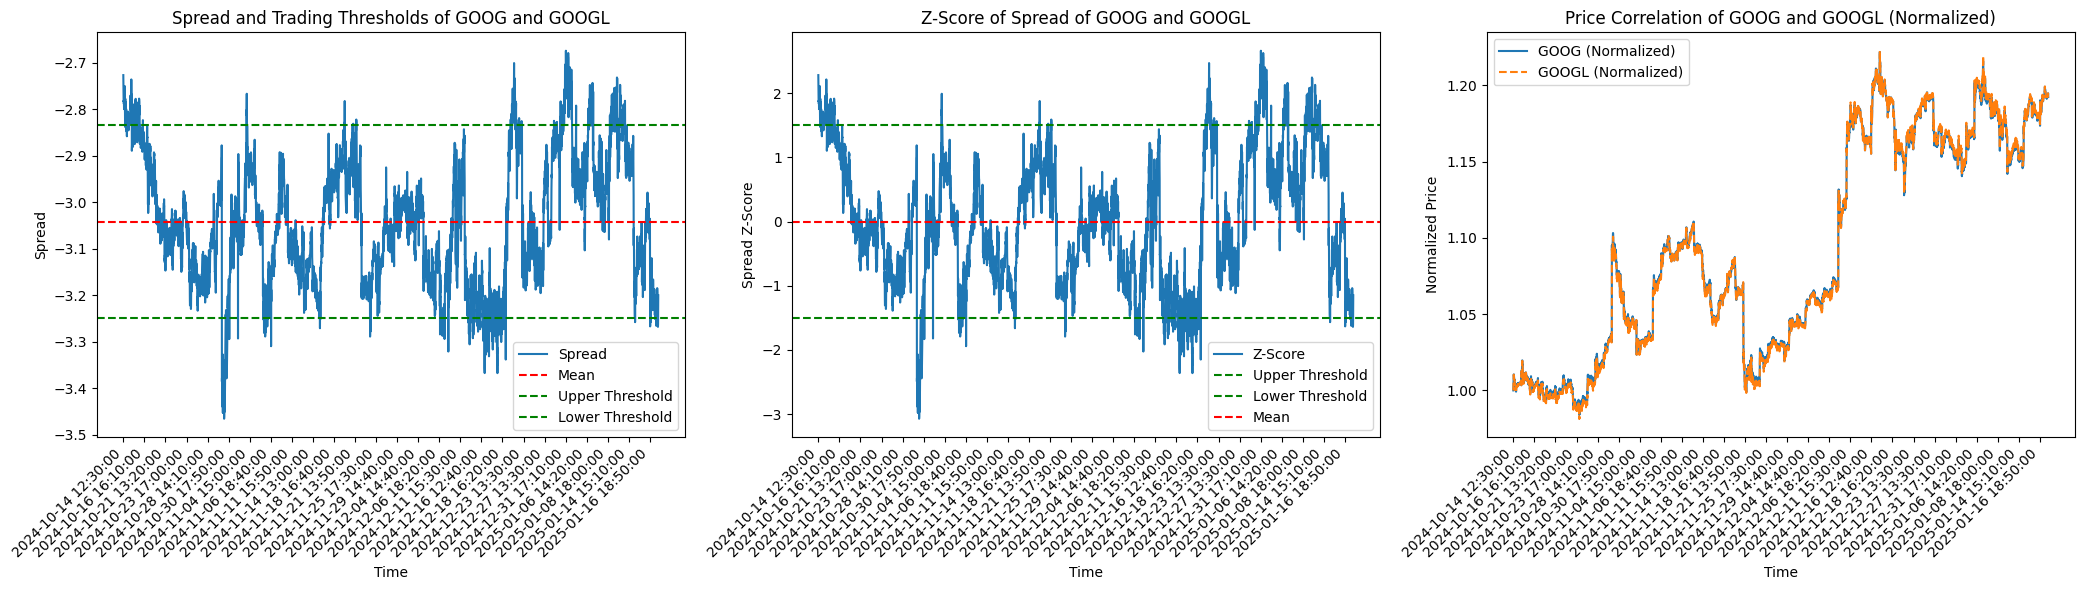

Pair: META & DAXEX_ETF
Correlation: 0.889

Spread ADF Statistic: -2.9171
p-value: 0.043 (Spread is stationary)

Cointegration Test Statistic: -3.4831
p-value: 0.034 (Both series are cointegrated)


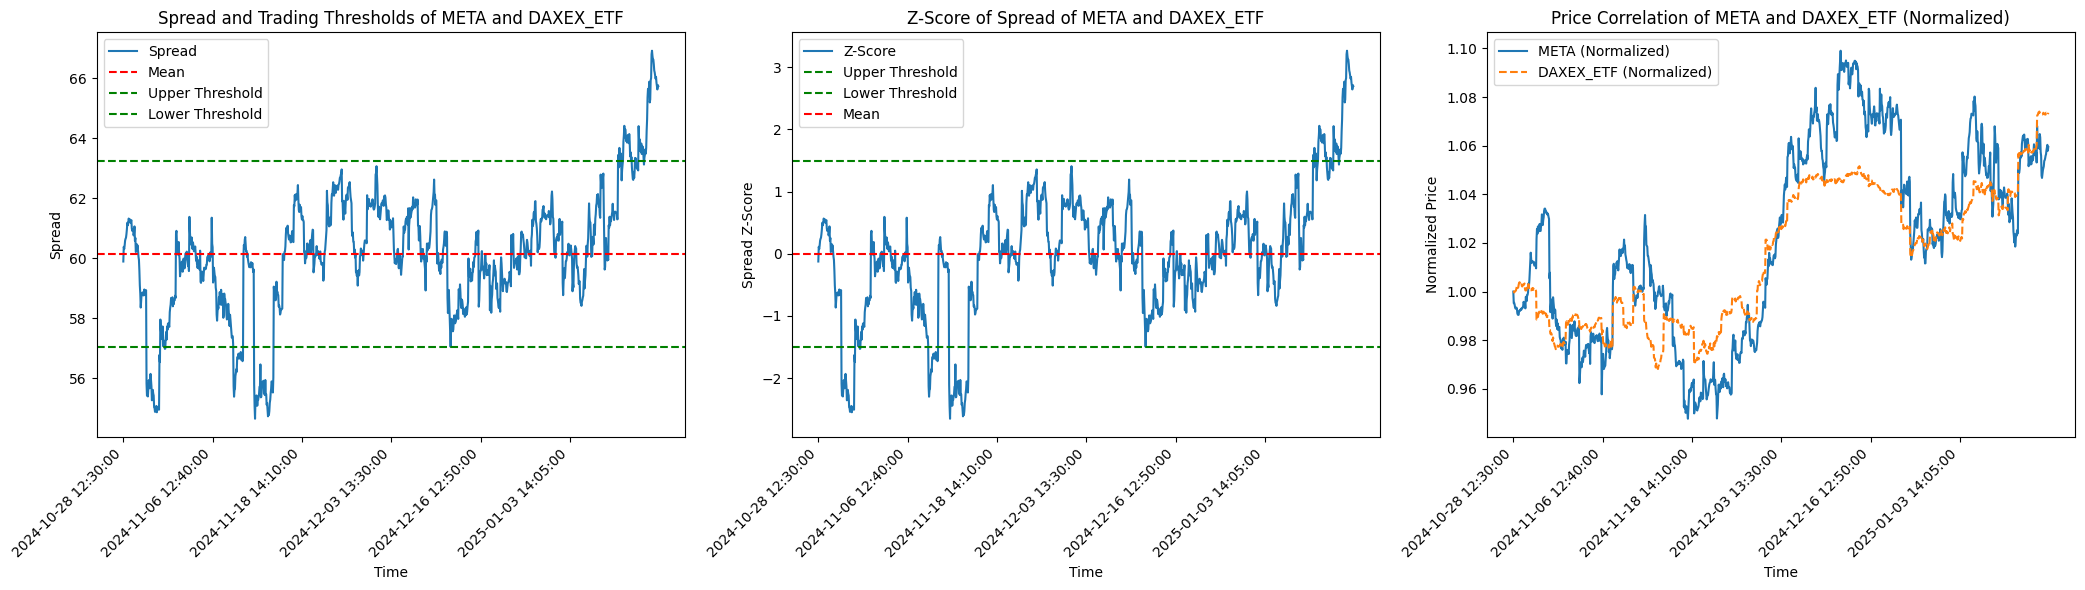

Pair: SPY_ETF & AVAXUSDT
Correlation: 0.870

Spread ADF Statistic: -3.2786
p-value: 0.016 (Spread is stationary)

Cointegration Test Statistic: -3.5990
p-value: 0.025 (Both series are cointegrated)


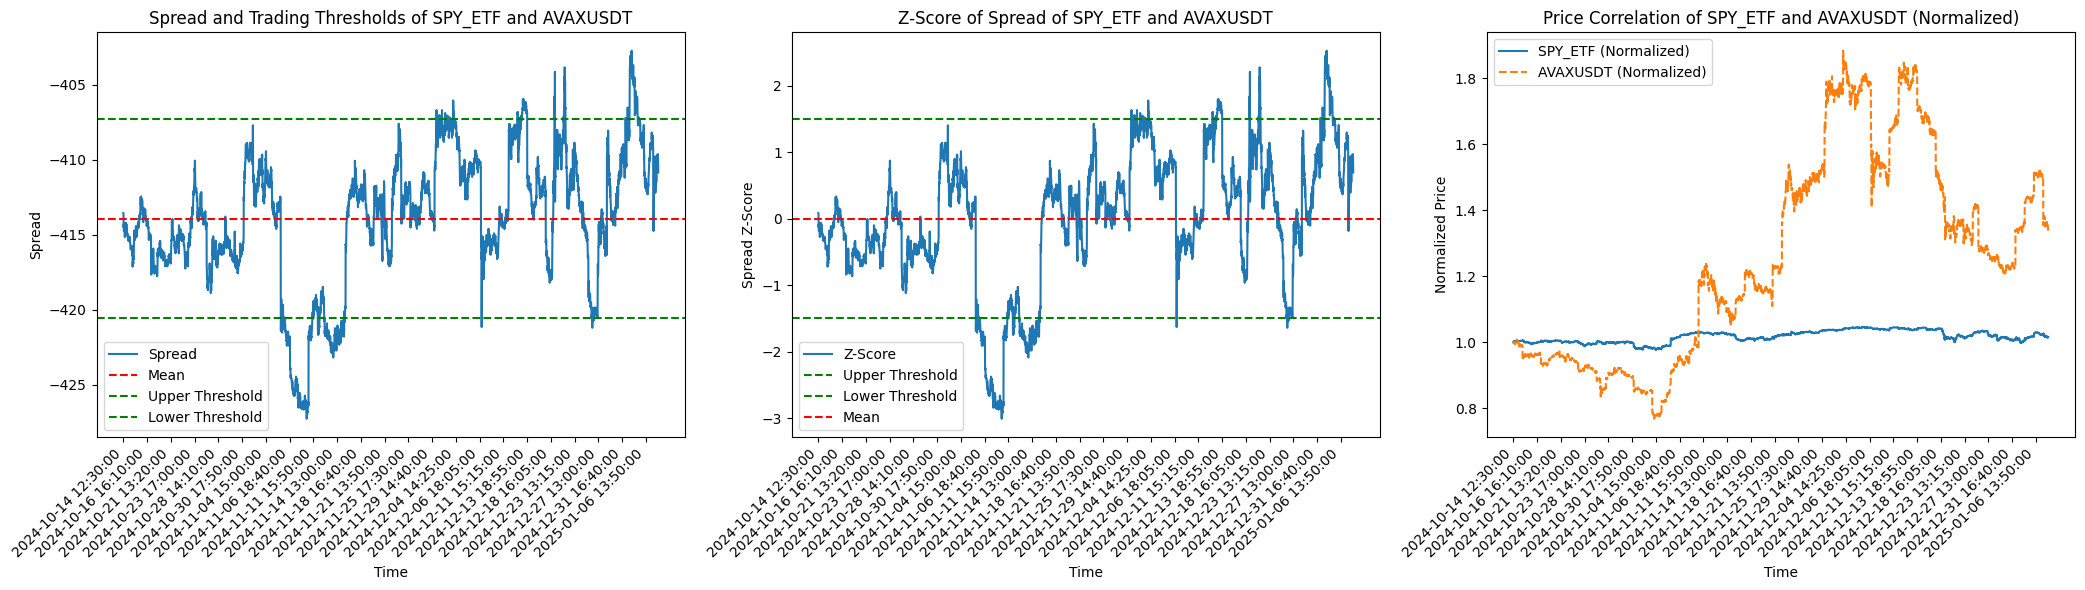

Pair: SPY_ETF & ETHUSDT
Correlation: 0.890

Spread ADF Statistic: -3.4334
p-value: 0.010 (Spread is stationary)

Cointegration Test Statistic: -3.6933
p-value: 0.019 (Both series are cointegrated)


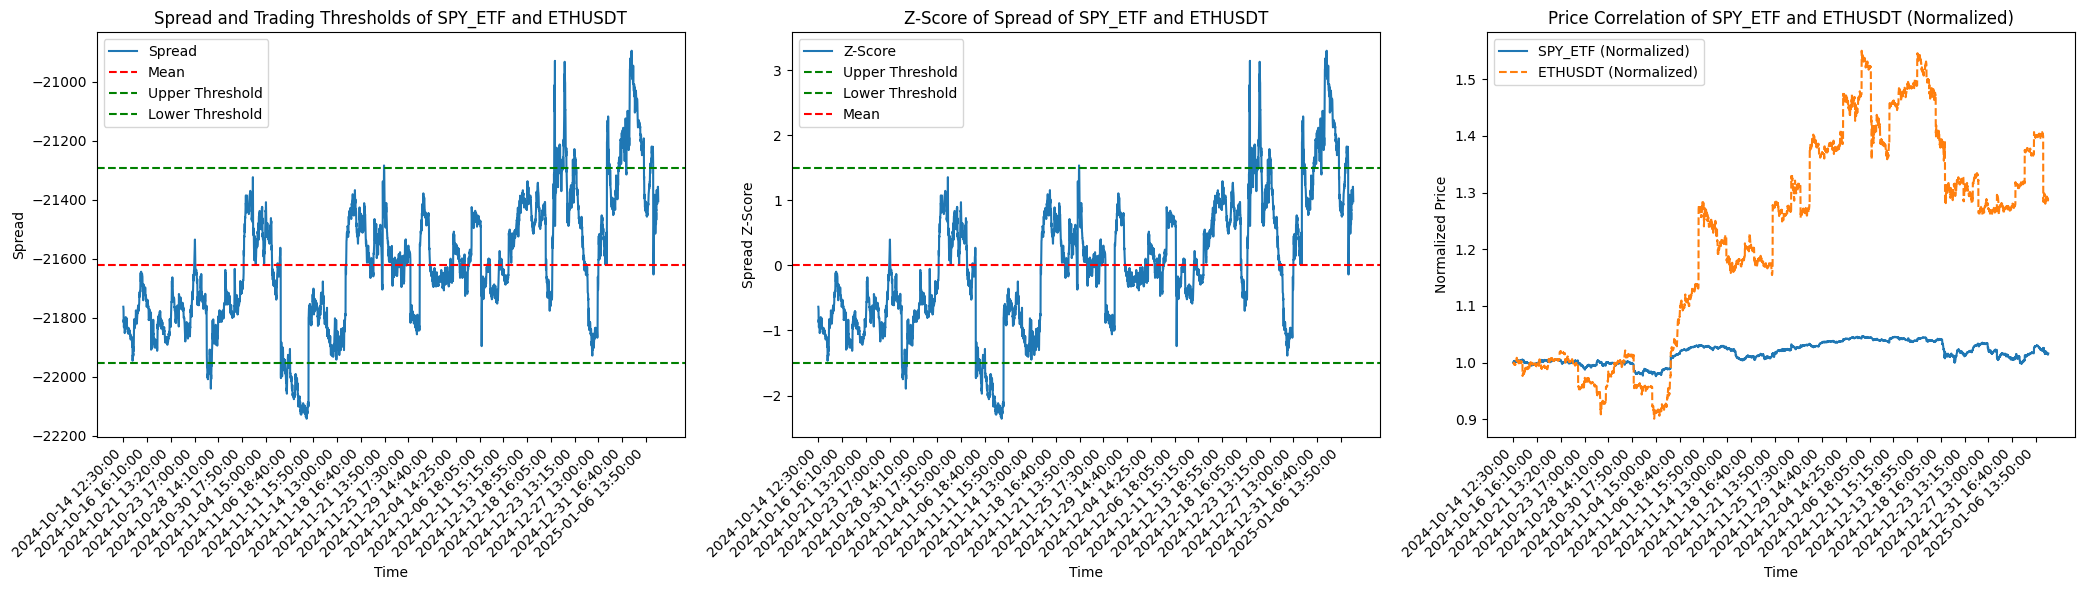

Pair: EQQQ_ETF & BNBUSDT
Correlation: 0.899

Spread ADF Statistic: -3.9159
p-value: 0.002 (Spread is stationary)

Cointegration Test Statistic: -3.9610
p-value: 0.008 (Both series are cointegrated)


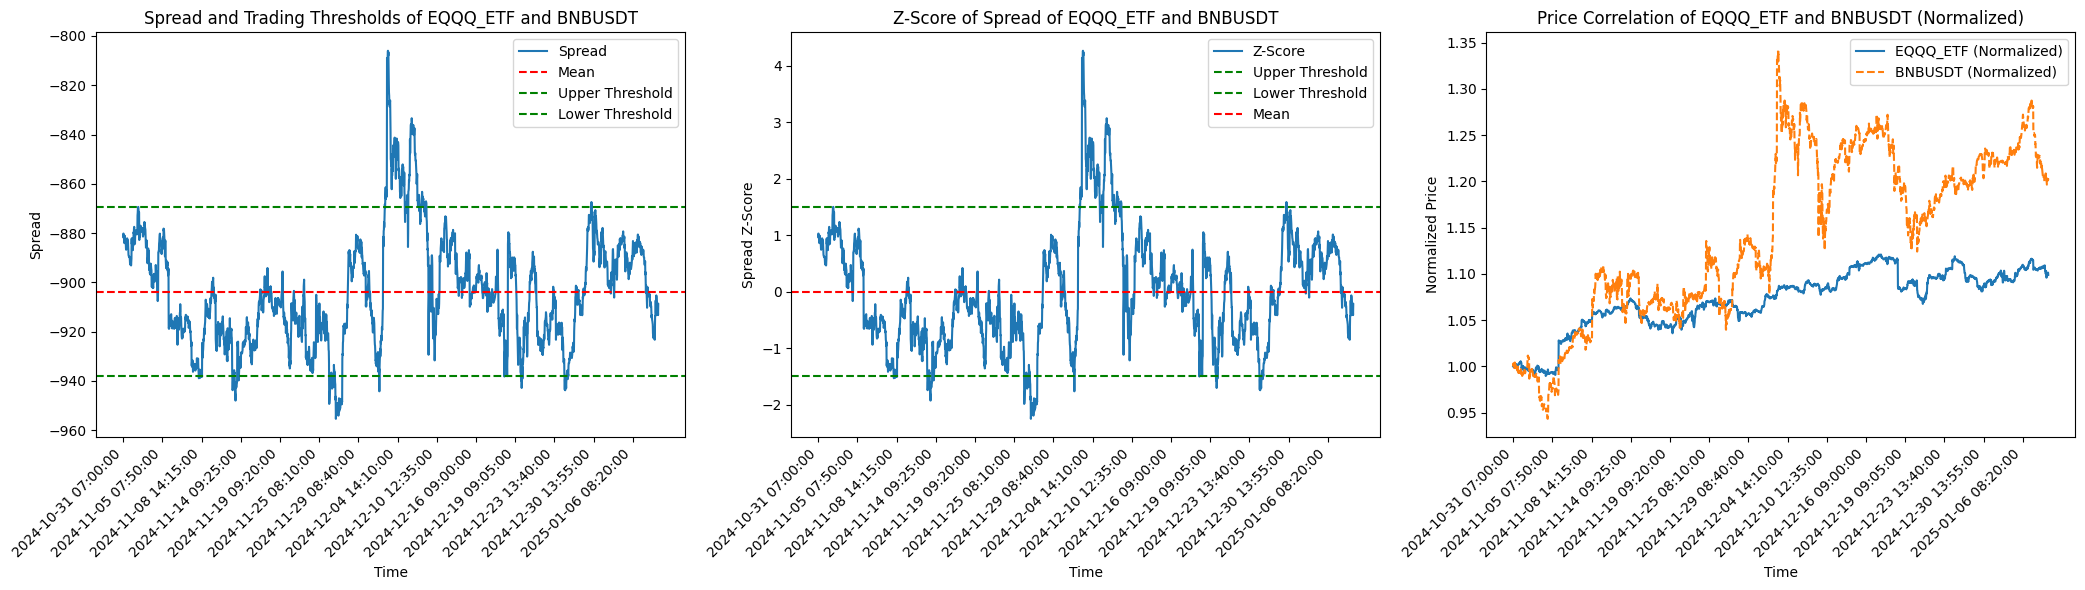

Pair: BNBUSDT & ADAUSDT
Correlation: 0.893

Spread ADF Statistic: -3.0524
p-value: 0.030 (Spread is stationary)

Cointegration Test Statistic: -3.5091
p-value: 0.032 (Both series are cointegrated)


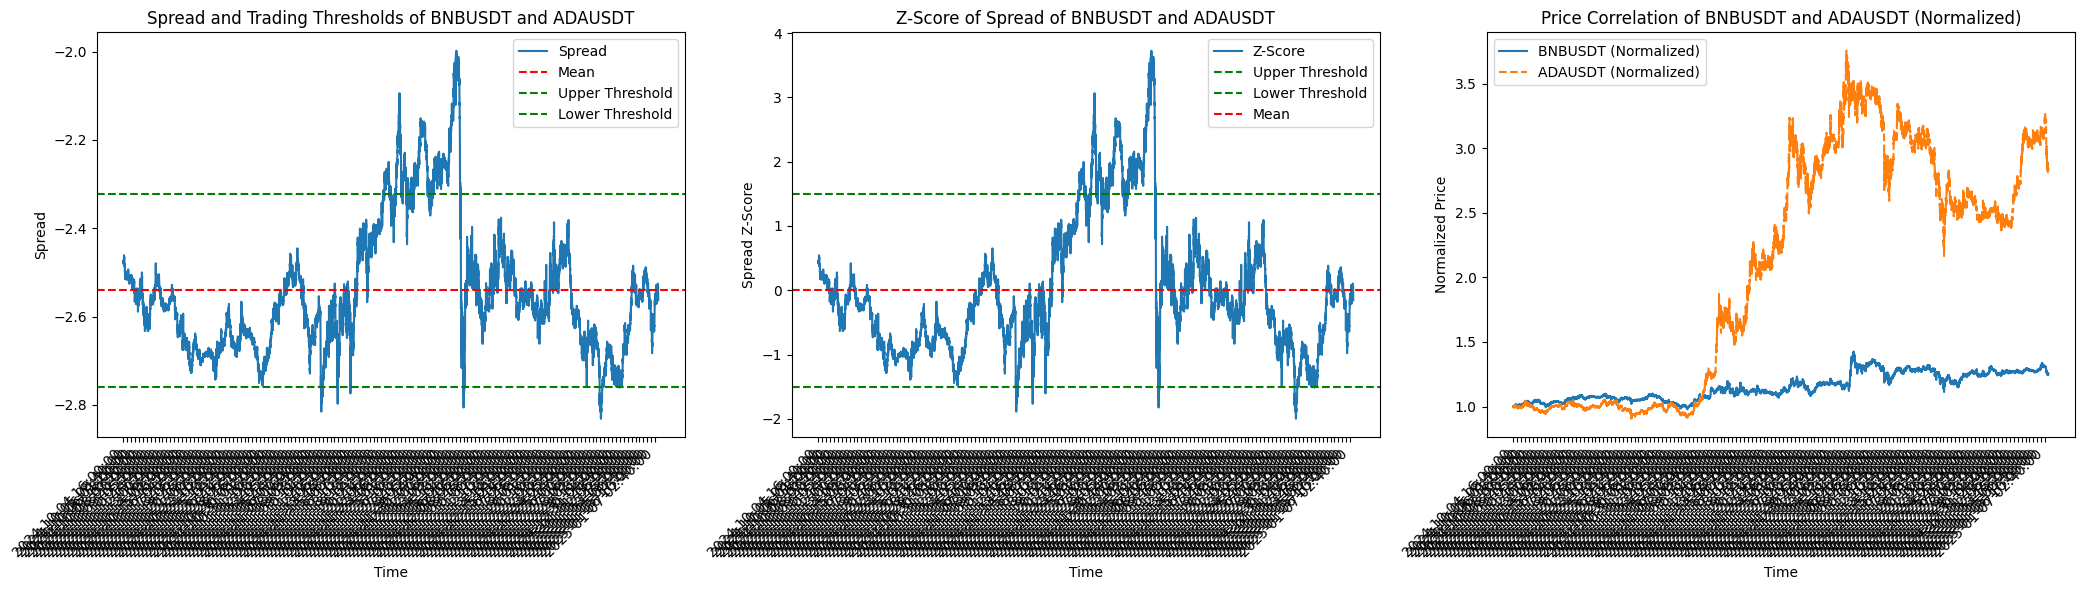

Pair: BNBUSDT & ETHUSDT
Correlation: 0.921

Spread ADF Statistic: -3.1149
p-value: 0.025 (Spread is stationary)

Cointegration Test Statistic: -3.4323
p-value: 0.039 (Both series are cointegrated)


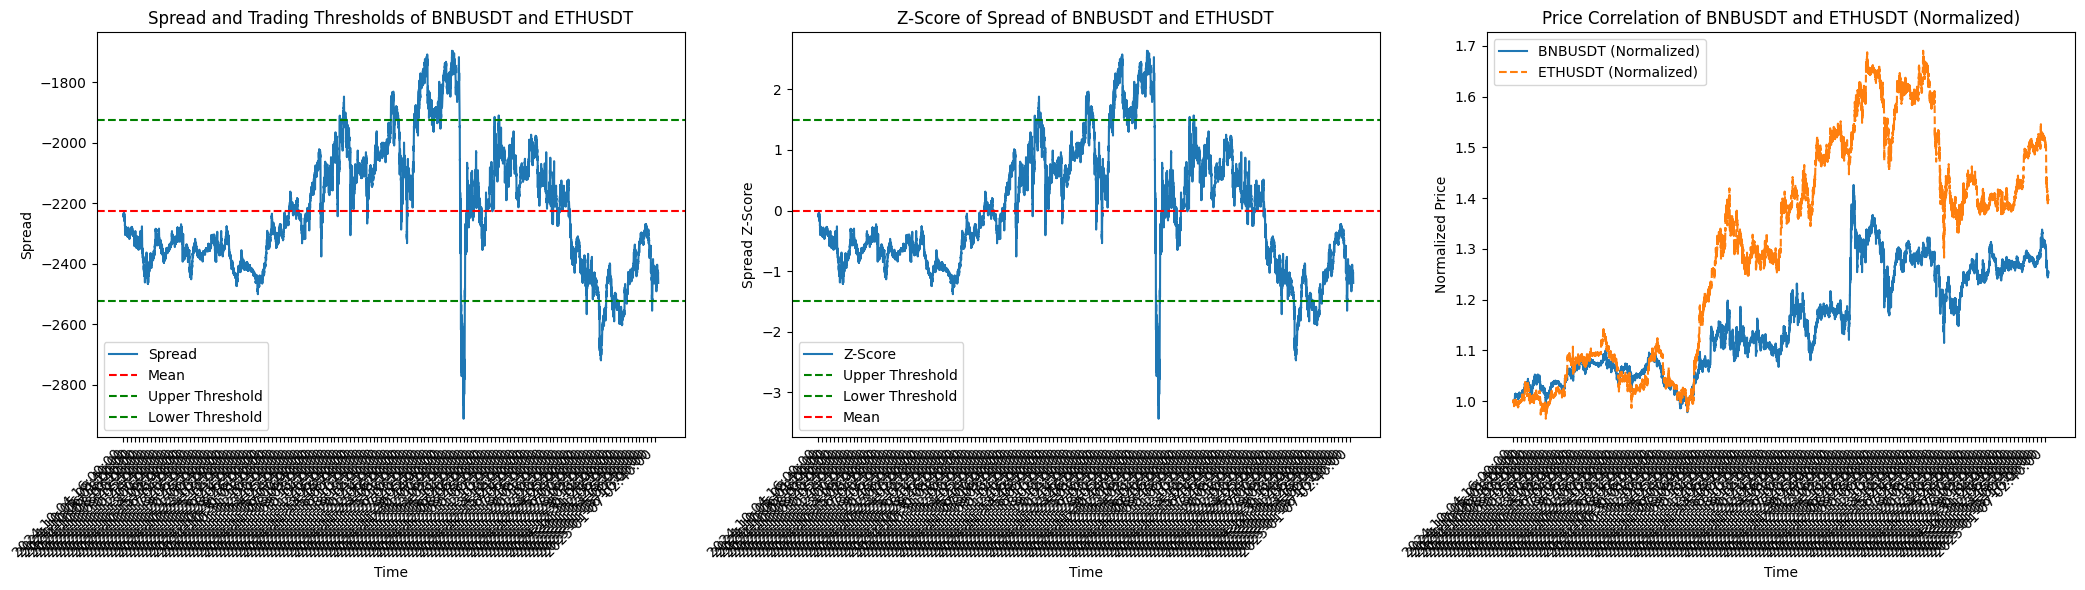

Pair: BNBUSDT & TRXUSDT
Correlation: 0.945

Spread ADF Statistic: -3.9962
p-value: 0.001 (Spread is stationary)

Cointegration Test Statistic: -4.2008
p-value: 0.004 (Both series are cointegrated)


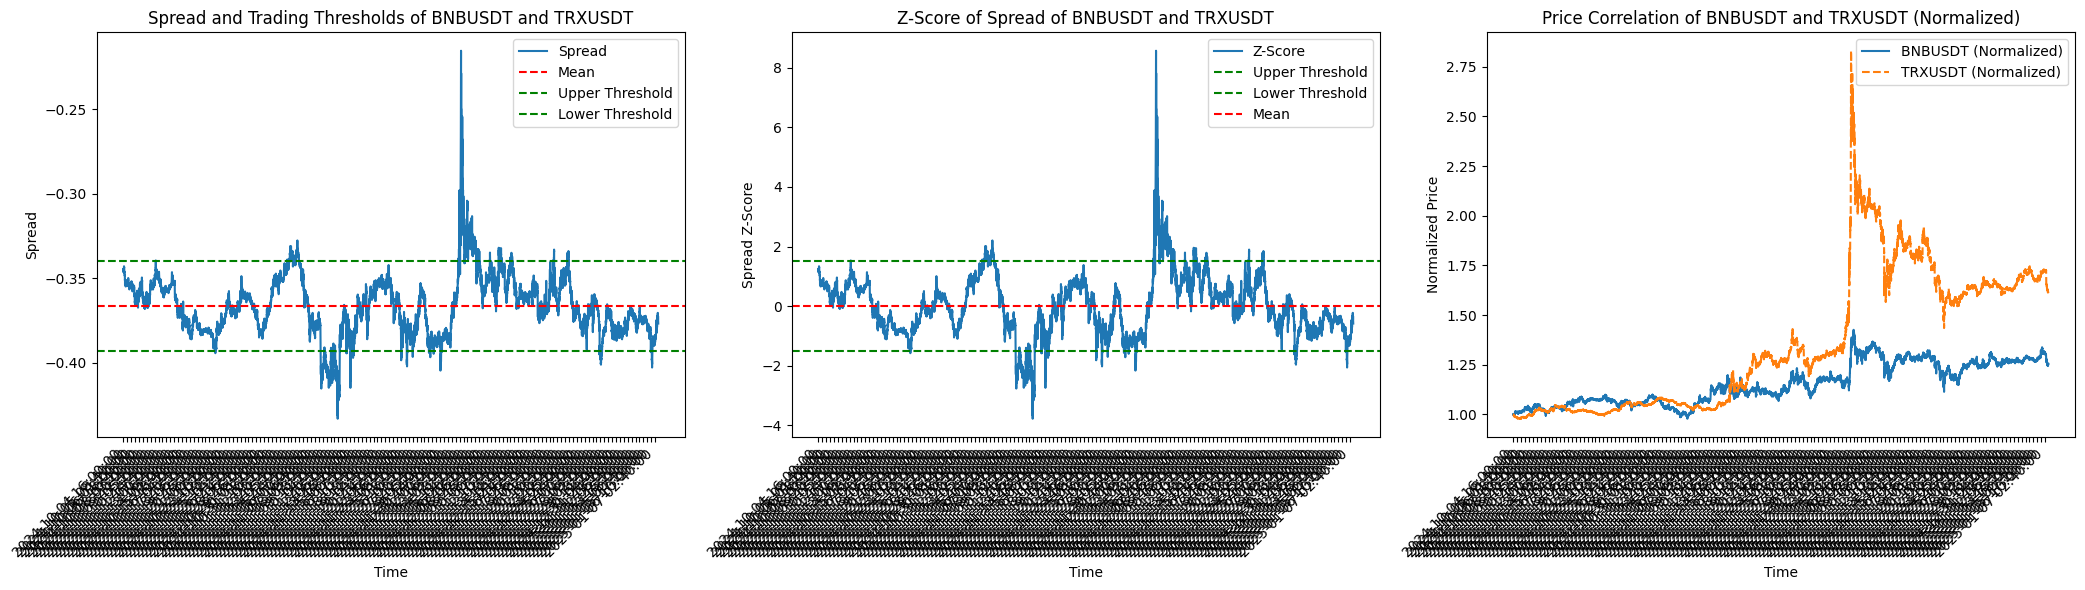

Pair: BNBUSDT & XRPUSDT
Correlation: 0.931

Spread ADF Statistic: -4.2134
p-value: 0.001 (Spread is stationary)

Cointegration Test Statistic: -4.6398
p-value: 0.001 (Both series are cointegrated)


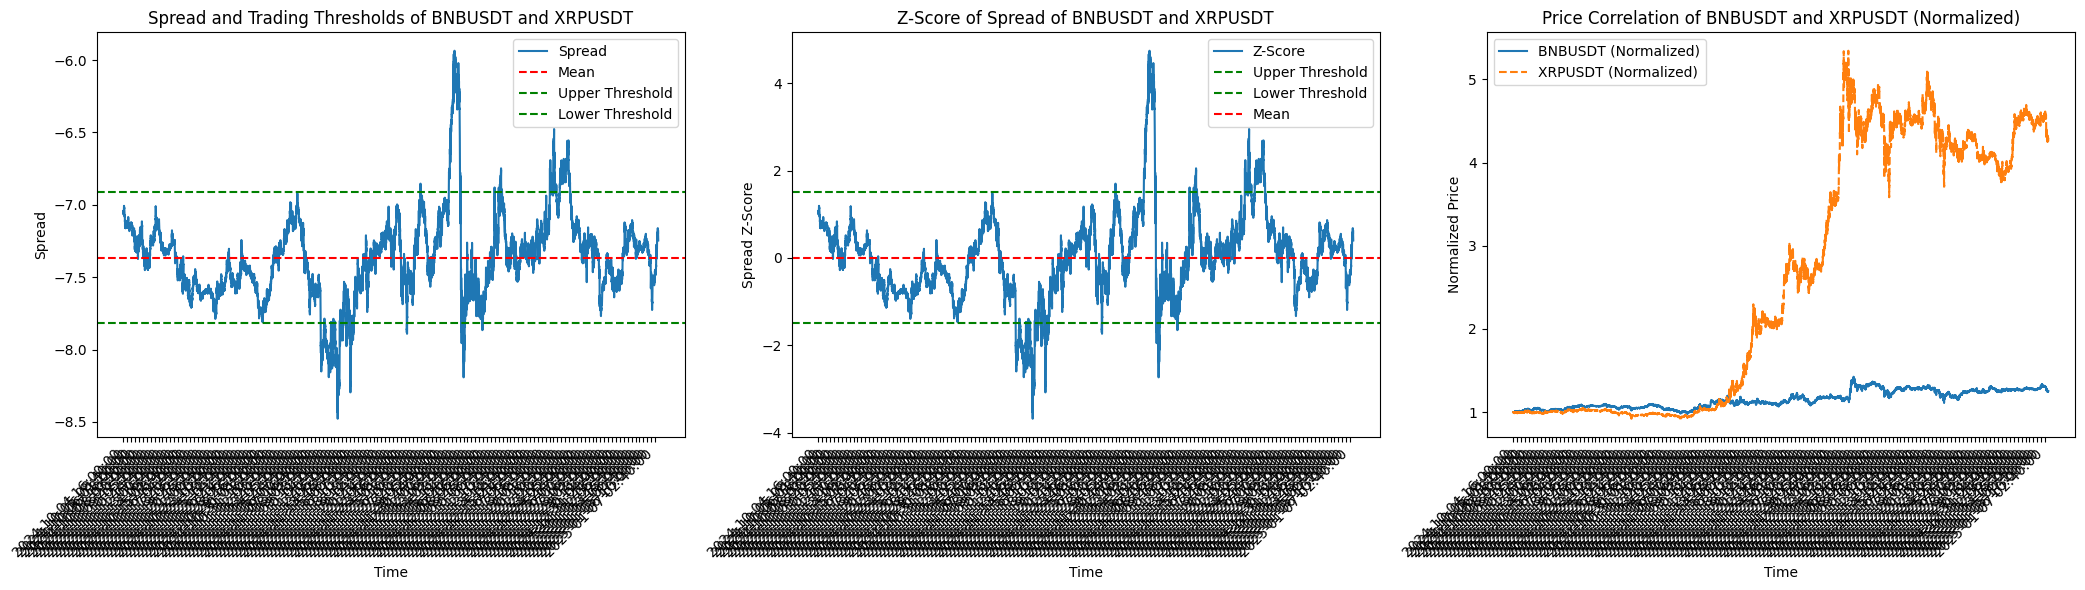

Pair: TRXUSDT & XRPUSDT
Correlation: 0.933

Spread ADF Statistic: -3.3585
p-value: 0.012 (Spread is stationary)

Cointegration Test Statistic: -3.6232
p-value: 0.023 (Both series are cointegrated)


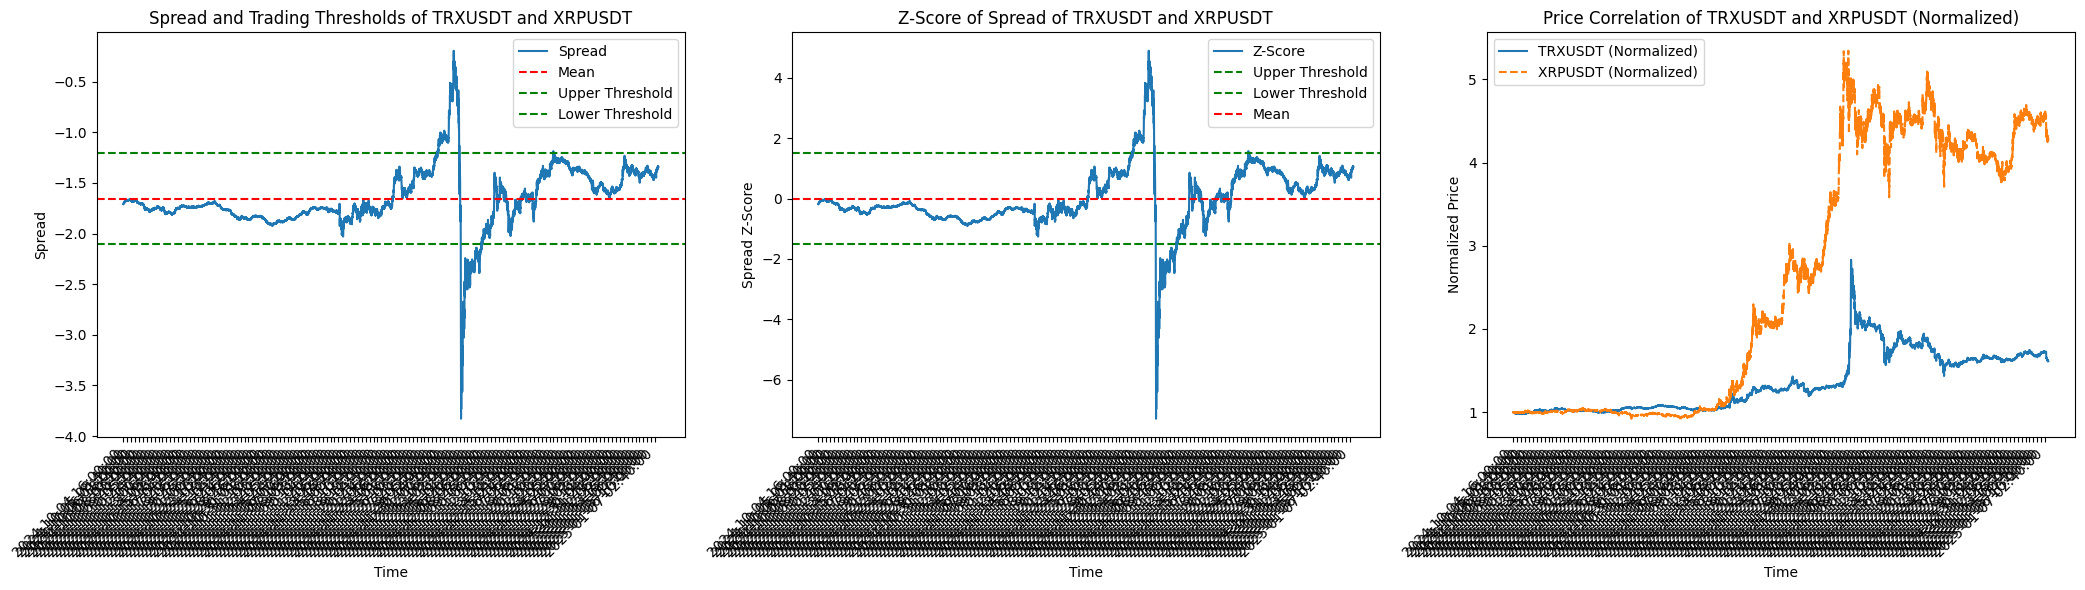

In [19]:
spread_stationary = True
series_cointegrated = True
correlation = 0.8

print('*****Stationary spread, cointegration and correlation >= 0.8*****')
filtered = df_results[(df_results['spread_stationary']==spread_stationary)
                      & (df_results['series_cointegrated']==series_cointegrated)
                      & (df_results['correlation']>=correlation)
                      ].copy()
filtered['pair_sorted'] = filtered.apply(lambda x: tuple(sorted([x['seriesX'],
                                                                 x['seriesY']])),
                                                                 axis=1)
filtered = filtered.drop_duplicates(subset=['pair_sorted'])
filtered = filtered.drop(['pair_sorted'], axis=1)
display(filtered)
print(f'Number of pairs: {len(filtered)}')

for i, r in filtered.iterrows():
    ticker_eqt = r['seriesX']
    ticket_cpy = r['seriesY']
    price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df=df_full)
    spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs,
                                                                           print_stats=True,
                                                                           plotting=True,
                                                                           std=1.5)